# Simulate genomes

Most dependencies are in `environment.yml`, except for [INDELible](http://abacus.gene.ucl.ac.uk/software/indelible/) which has to be installed manually.

## Clean directories

In [1]:
import shutil
import os

output_dir = 'output'
phylo_dir = 'phylogeny'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
if os.path.exists(phylo_dir):
    shutil.rmtree(phylo_dir)

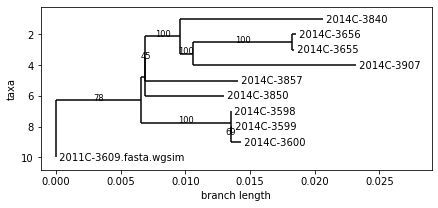

In [2]:
from Bio import Phylo
import matplotlib.pyplot as plt

input_tree = 'input/tree.tre'
outgroup = '2011C-3609.fasta.wgsim'

t = Phylo.read(input_tree, 'newick')
t.root_with_outgroup(outgroup)
plt.rcParams['figure.figsize'] = (7,3)
Phylo.draw(t)

In [3]:
input_fasta = 'input/2011C-3609.fasta'

config_data = f'''
#REQUIRED PARAMETERS
treefile_path = {input_tree}
number_of_variable_sites = 1000
base_genome_name = {outgroup}
base_genome_path = {input_fasta}
output_dir = {output_dir}

#parameters of evolutionary model (comma seperated), in order ac, ag, at, cg, ct, gc (gc = 1)
rate_matrix = 1,1,1,1,1,1

#Optional evolutionary model parameters
gamma_shape = 5  #default is no rate variation across sites

#parameters for clustering of variable site locations (OPTIONAL)
mutation_clustering = ON
percent_clustered = 0.25 #The percentage of variable sites whose distance to another site is drawn from the clustering distribution
exponential_mean = 125 #Minimum allowed value = 2

# Don't run ART to simulate reads (or run with minimal reads). Instead, simulate afterwards (so I can run in parallel)
coverage = 0
'''

config_file = 'input/simulation.config'
with open(config_file, 'w') as conf:
    conf.write(config_data)
    print(f'Config file written to [{config_file}]')

Config file written to [input/simulation.config]


In [4]:
!python TreeToReads/treetoreads.py {config_file}

Random seed is 3242661298495566790
Running TreetoReads using configuration file input/simulation.config
Arguments read
Number of variable sites is 1000
clustering proportion is 0.25
exponential_mean is 2
output directory is output
Base frequencies detected from anchor genome A:0.24739565531789579 C:0.2598565665918917 G:0.246951513536902 T:0.2457962645533105
genome has 7 contigs
Genome has 5412686 bases
Tree read
Variable sites generated using seq-gen
3 variable sites with more than 2 bases out of 1223 sites.
            Scale down tree length if this is too high.
writing genome for 2014C-3840
writing genome for 2014C-3656
writing genome for 2014C-3655
writing genome for 2014C-3907
writing genome for 2014C-3857
writing genome for 2011C-3609.fasta.wgsim
writing genome for 2014C-3598
writing genome for 2014C-3599
writing genome for 2014C-3600
writing genome for 2014C-3850
Mutated genomes
coverage is 0
read length is 150
fragment size is 350
stdev of frag size is 130
Generating reads for 2

In [5]:
!ls {output_dir}

analysis_configuration.cfg  fastq	    seqgen_log	  simtree.tre
art_log			    mutsites.txt    seqs_sim.txt  var_site_matrix
fasta_files		    scaledtree.tre  sim.vcf


# Simulate reads

In [6]:
import os
import glob
import shutil

# Get rid of Perl LANG warning
os.environ['LANG'] = 'en_US.UTF-8'

reads_dir = f'{output_dir}/fastq'
# Delete unneded empty read files
shutil.rmtree(reads_dir)
os.mkdir(reads_dir)

genomes_dir = f'{output_dir}/fasta_files'

genomes = [os.path.basename(genome).rstrip('.fasta') for genome in glob.glob(f'{genomes_dir}/*.fasta')]

# Don't simulate reads for outgroup since it will already be in the tree
genomes.remove(outgroup)

command = f"'art_illumina --paired -f 50 -l 250 -m 550 -s 100 -na -o {reads_dir}/%_ --in {genomes_dir}/%.fasta > {reads_dir}/%.log 2>&1 && gzip {reads_dir}/%_1.fq && gzip {reads_dir}/%_2.fq'"
!parallel -j 12 -I% {command} ::: {' '.join(genomes)}

# Build alignment

In [19]:
!conda run --name snippy snippy --version 2>/dev/null

snippy 4.6.0



In [20]:
import os
import glob

reference_file_abs = os.path.abspath(input_fasta)
snippy_out = os.path.abspath(phylo_dir)
snippy_fofn = os.path.abspath(f'{output_dir}/snippy.fofn')

if not os.path.exists(snippy_out):
    os.mkdir(snippy_out)

with open(snippy_fofn, 'w') as f:
    for genome in genomes:       
        files = [f'{reads_dir}/{genome}_1.fq.gz', f'{reads_dir}/{genome}_2.fq.gz']
        files = [os.path.abspath(f) for f in files]
        values = [genome]
        values.extend(files)
        f.write('\t'.join(values)+'\n')

In [21]:
!head -n 1 {snippy_fofn}

2014C-3857	/home/CSCScience.ca/apetkau/workspace/thesis-data-simulation/treestoreads/output/fastq/2014C-3857_1.fq.gz	/home/CSCScience.ca/apetkau/workspace/thesis-data-simulation/treestoreads/output/fastq/2014C-3857_2.fq.gz


In [22]:
!conda run --name snippy snippy-multi {snippy_fofn} --ref {reference_file_abs} --cpus 6\
    > {snippy_out}/snippy-commands-all.sh

snippy_commands_variant = f'{snippy_out}/snippy-commands-variant.sh'
snippy_commands_core = f'{snippy_out}/snippy-commands-core.sh'

# Split commands so they can be run in parallel
!head -n-2 {snippy_out}/snippy-commands-all.sh > {snippy_commands_variant}
!tail -n 2 {snippy_out}/snippy-commands-all.sh > {snippy_commands_core}

Reading: /home/CSCScience.ca/apetkau/workspace/thesis-data-simulation/treestoreads/output/snippy.fofn
Generating output commands for 9 isolates
Done.



In [23]:
# Variant calling in parallel
!(pushd {snippy_out} && conda run --name snippy \
  parallel -j 12 -a {snippy_commands_variant} \
  && popd) > {snippy_out}/snippy-variant.log 2>&1

# Core alignment command
!(pushd {snippy_out} && conda run --name snippy \
  bash {snippy_out}/snippy-commands-core.sh && popd) \
  > {snippy_out}/snippy-core.log 2>&1

In [24]:
!tail {snippy_out}/snippy-core.log

Processing contig: JASV01000005.1
Processing contig: JASV01000006.1
Processing contig: JASV01000007.1
Generating core.full.aln
Creating TSV file: core.txt
Running: snp-sites -c -o core.aln core.full.aln
The Snippy manual is at http://github.com/tseemann/snippy/blob/master/README.md
Done.

~/workspace/thesis-data-simulation/treestoreads


In [25]:
!column -s$'\t' -t {snippy_out}/core.txt

ID          LENGTH   ALIGNED  UNALIGNED  VARIANT  HET  MASKED  LOWCOV
2014C-3598  5412686  5103307  284795     206      700  0       23884
2014C-3599  5412686  5103307  284795     207      700  0       23884
2014C-3600  5412686  5103307  284795     216      700  0       23884
2014C-3655  5412686  5102300  284555     287      685  0       25146
2014C-3656  5412686  5102300  284555     284      685  0       25146
2014C-3840  5412686  5102232  284543     310      683  0       25228
2014C-3850  5412686  5102222  284527     199      666  0       25271
2014C-3857  5412686  5102274  284563     211      679  0       25170
2014C-3907  5412686  5103113  284719     354      691  0       24163
Reference   5412686  5412686  0          0        0    0       0


# Build tree

In [26]:
# Swap 'Reference' with actual name
!sed -i.bak -e 's/Reference/{outgroup}/' {snippy_out}/core.aln

In [27]:
!iqtree -s {snippy_out}/core.aln -redo | tail -n 20

OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Optimal log-likelihood: -4341.530
Rate parameters:  A-C: 1.00000  A-G: 1.00000  A-T: 1.00000  C-G: 1.00000  C-T: 1.00000  G-T: 1.00000
Base frequencies:  A: 0.250  C: 0.250  G: 0.250  T: 0.250
Parameters optimization took 1 rounds (0.000 sec)
BEST SCORE FOUND : -4341.530
Total tree length: 0.011

Total number of iterations: 102
CPU time used for tree search: 0.448 sec (0h:0m:0s)
Wall-clock time used for tree search: 0.448 sec (0h:0m:0s)
Total CPU time used: 0.467 sec (0h:0m:0s)
Total wall-clock time used: 0.470 sec (0h:0m:0s)

Analysis results written to: 
  IQ-TREE report:                /home/CSCScience.ca/apetkau/workspace/thesis-data-simulation/treestoreads/phylogeny/core.aln.iqtree
  Maximum-likelihood tree:       /home/CSCScience.ca/apetkau/workspace/thesis-data-simulation/treestoreads/phylogeny/core.aln.treefile
  Likelihood distances:          /home/CSCScience.ca/apetkau/workspace/t

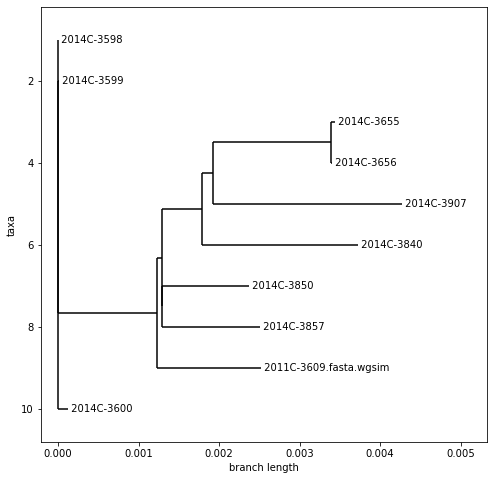

In [28]:
t = Phylo.read(f'{snippy_out}/core.aln.treefile', 'newick')
plt.rcParams['figure.figsize'] = (8,8)
Phylo.draw(t)